In [26]:
import findspark
findspark.init()
import pyspark # only run after findspark.init()

from pyspark.sql import SparkSession
from pyspark.context import SparkContext 
spark = SparkSession.builder.getOrCreate()#create spark session 
sc = spark.sparkContext#create sparkContext
from pyspark.sql.types import  (StructType, 
                                StructField, 
                                DateType, 
                                BooleanType,
                                DoubleType,
                                IntegerType,
                                StringType,
                                DecimalType,
                                LongType,
                                ArrayType,
                                TimestampType)


In [27]:

#Measurement Data File Format

#The header line of the measurement data files is as follows:
#id,timeAtServer,aircraft,latitude,longitude,baroAltitude,geoAltitude,numMeasurements,measurements

#1-id: a unique identifier for each received transponder signal. This identifier will be used to join the result file (output of your localization algorithm) with the measurement data.
#2-timeAtServer: a timestamp (double) in seconds indicating the time when the information was received by OpenSky's ingestion server.
#In each 1h data set, this timestamp starts with 0 and counts up to 3600 seconds. 
#This timestamp has roughly millisecond accuracy. 
#Note that this timestamp was determined after propagation delay, processing delay, and Internet delay.
#3-aircraft: an aircraft identifier which is unique for each aircraft within each data set. 
#This identifier allows grouping the measurements that belong to signals from the same transponder.
#Note that aircraft 123 in data set X is not the same transponder as aircraft 123 in data set Y. 
#This means that data sets cannot be combined.
#4-latitude/longitude/geoAltitude: the location that was reported by the transmitting aircraft. 
#As in the sensor meta data, latitude and longitude are provided in decimal degrees (WGS84), geoAltitude in meters. 
#The accuracy of these location information is generally unknown. 
#However, most aircraft should report their locations at a decent accuracy (10s of meters accuracy). 
#It is worth noting here that there are some aircraft sending location information derived from their intertial system rather that their GPS sensor.
#In this case, location information is subject to drifting and might be wrong by several hundred meters. 
#However, this case is rather rare but should nevertheless be considered when cleansing the data.
#5-baroAltitude: the barometric altitude reported by the aircraft in meters. 
#Note that the barometric altitude is weather dependent and might differ from the geometric altitude by several hundred meters.
#However, the difference might be learned from "known" aircraft and this information could then be used to estimate the geometric altitude or estimate bounds.
#6-numMeasurements: the number of measurements, i.e., the number of sensors which received this particular transponder signal.
#7-measurements: the measurement data for each receiver which received this particular transponder signal. 
#The measurement data is provided as a JSON array string containing triples.
#Each triple contains the serial number of the sensor which reported the measurement data, the timestamp for the time of arrival of the signal at the receiver (in nanoseconds), and the received signal strength indicator (RSSI).
#The exact definition of the RSSI depends on the type of receiver but is usually provided in dB. 
#The properties of the nanosecond timestamp also strongly depend of the type of receiver. 
#For dump1090 receivers, these timestamps are generally unsynchronized and typically have a 12MHz resolution. 
#Unsynchronized timestamp means in particular that these timestamps are subject to (sometimes heavy) drifting. 
#For Radarcape and GRX1090, these timestamps are usually GPS synchronized and have a resolution of about 40-60MHz. GPS synchronized means that they are constantly resynchronized to compensate for clock drift.
sample_schema = StructType([StructField("id",  IntegerType(), True),
                            StructField("timeAtServer", DoubleType(), True),
                            StructField("aircraft",  IntegerType(), True ),
                            StructField("latitude", DoubleType(), True),
                            StructField("longitude", DoubleType(), True  ),
                            StructField("baroAltitude", DoubleType(), True ),
                            StructField("geoAltitude", DoubleType(), True ),
                            StructField("numMeasurements",IntegerType(), True),
                            StructField("measurements", StringType(), True)           
                            ])
                               

sample_aircarft = spark.read.csv("C:/Users/rzouga/Desktop/PFE/TEST/sample.csv",
                       header = True, 
                        schema = sample_schema)


sample_aircarft.show(10)


+---+-------------------+--------+----------------+----------------+------------+-----------+---------------+--------------------+
| id|       timeAtServer|aircraft|        latitude|       longitude|baroAltitude|geoAltitude|numMeasurements|        measurements|
+---+-------------------+--------+----------------+----------------+------------+-----------+---------------+--------------------+
|  1|                0.0|    1787|49.5238952636719|7.80282271535773|      6400.8|    6537.96|              3|[[463,963309455,4...|
|  2|                0.0|    1605|50.4821311821372|7.35423320048564|     10363.2|   10500.36|              5|[[463,963756980,2...|
|  3|                0.0|    2022|45.9829505015228|8.61870574951172|     11277.6|   11445.24|              3|[[14,981538828,29...|
|  4|0.00100016593933105|    2359|47.8106379104873|9.30739182692308|     10820.4|   10965.18|              2|[[125,957894484,8...|
|  5|0.00100016593933105|    1283|49.8303533004502|5.40037412901183|      9753.6|  

In [28]:
#sort our data  by distinct aircraft and time at server 
sorted_flights =sample_aircarft.orderBy('aircraft','timeAtServer')
sorted_flights.show()

+----+-----------------+--------+----------------+----------------+------------+-----------+---------------+--------------------+
|  id|     timeAtServer|aircraft|        latitude|       longitude|baroAltitude|geoAltitude|numMeasurements|        measurements|
+----+-----------------+--------+----------------+----------------+------------+-----------+---------------+--------------------+
| 299|0.523000001907349|       2|49.8963643736759|8.40246252111487|      2400.3|     2400.3|              3|[[440,1509552325,...|
| 615| 1.11700010299683|       2|49.8959454035355|8.40149750580659|     2407.92|    2407.92|              2|[[101,2104674703,...|
| 847| 1.54299998283386|       2|49.8956660901086|8.40075518633868|     2415.54|    2415.54|              3|[[101,2524676140,...|
|1117| 2.03600001335144|       2|49.8952789306641|8.39991519325658|     2423.16|    2423.16|              2|[[101,3024702015,...|
|1685| 3.12700009346008|       2|49.8945953886388|8.39786014041385|      2438.4|    2446.0

In [29]:
#exapmle of a flight trip 296
trip296=sorted_flights.filter('aircraft= 296')
trip296.show(5)

+----+-----------------+--------+----------------+----------------+------------+-----------+---------------+--------------------+
|  id|     timeAtServer|aircraft|        latitude|       longitude|baroAltitude|geoAltitude|numMeasurements|        measurements|
+----+-----------------+--------+----------------+----------------+------------+-----------+---------------+--------------------+
| 220|0.425000190734863|     296|50.4569929737156|7.42067079286318|     10668.0|   10812.78|              4|[[320,1405224250,...|
| 516|0.942000150680542|     296|50.4567260742188|7.42263793945312|     10668.0|   10812.78|              2|[[394,1915311265,...|
| 823| 1.50300002098084|     296|50.4564343468618|7.42460508604308|     10668.0|   10812.78|              3|[[101,2495094109,...|
|1066| 1.94500017166138|     296|50.4562946901483|7.42586702913851|     10668.0|   10812.78|              2|[[115,2904190750,...|
|1617| 3.00600004196167|     296|50.4558563232422|7.42914300215872|     10668.0|   10812.7

In [30]:
#this is a complete csv of airports with correct names 
airport_schema = StructType([StructField("id",IntegerType(), True),
                            StructField("ident", StringType(), True),
                            StructField("type", StringType(), True ),
                            StructField("name", StringType(), True),
                            StructField("latitude_deg", DoubleType(), True  ),
                            StructField("longitude_deg", DoubleType(), True ),
                            StructField("elevation_ft", DoubleType(), True ),
                            StructField("continent",StringType(), True),
                            StructField("iso_country",StringType(), True),
                            StructField("iso_region", StringType(), True),
                            StructField("municipality", StringType(), True),
                            StructField("scheduled_service", StringType(), True),
                            StructField("gps_code", StringType(), True),
                             StructField("iata_code", StringType(), True),
                            StructField("local_code", StringType(), True),
                            StructField("home_link", StringType(), True),
                             StructField("wikipedia_link", StringType(), True),
                            StructField("keywords", StringType(), True)
                            ])


airport = spark.read.csv("C:/Users/rzouga/Desktop/PFE/TEST/airports.csv",
                       header = True, 
                        schema = airport_schema)
print(airport.count())
airport.show(5)


55536
+------+-----+-------------+--------------------+-----------------+------------------+------------+---------+-----------+----------+------------+-----------------+--------+---------+----------+---------+--------------+--------+
|    id|ident|         type|                name|     latitude_deg|     longitude_deg|elevation_ft|continent|iso_country|iso_region|municipality|scheduled_service|gps_code|iata_code|local_code|home_link|wikipedia_link|keywords|
+------+-----+-------------+--------------------+-----------------+------------------+------------+---------+-----------+----------+------------+-----------------+--------+---------+----------+---------+--------------+--------+
|  6523|  00A|     heliport|   Total Rf Heliport|   40.07080078125|-74.93360137939453|        11.0|       NA|         US|     US-PA|    Bensalem|               no|     00A|     null|       00A|     null|          null|    null|
|323361| 00AA|small_airport|Aero B Ranch Airport|        38.704022|       -101.473

In [31]:
import geohash2
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.sql.functions import udf,col
from pyspark.sql.types import StringType
import pandas as pd
from math import radians, cos, sin, asin, sqrt
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
udf1 = F.udf(lambda x,y: geohash2.encode(x,y,precision=4))
trip296=trip296.select('latitude','longitude','geoAltitude','timeAtServer')
trip296=trip296.withColumn('Hash_Aircraft', udf1('latitude','longitude'))
trip296.show()

+----------------+----------------+-----------+-----------------+-------------+
|        latitude|       longitude|geoAltitude|     timeAtServer|Hash_Aircraft|
+----------------+----------------+-----------+-----------------+-------------+
|50.4569929737156|7.42067079286318|   10812.78|0.425000190734863|         u0vr|
|50.4567260742188|7.42263793945312|   10812.78|0.942000150680542|         u0vr|
|50.4564343468618|7.42460508604308|   10812.78| 1.50300002098084|         u0vr|
|50.4562946901483|7.42586702913851|   10812.78| 1.94500017166138|         u0vr|
|50.4558563232422|7.42914300215872|   10812.78| 3.00600004196167|         u0vr|
| 50.455596406581|7.43113749736064|   10812.78| 3.57500004768372|         u0vr|
|50.4554101976298|7.43239944045608|   10812.78| 4.09000015258789|         u0vr|
|50.4551696777344| 7.4344193307977|   10812.78| 4.61700010299683|         u0vr|
|50.4548981230138|7.43633373363598|   10812.78| 5.13400006294251|         u0vr|
|50.4547119140625|7.43766990867821|   10

In [32]:
#this give us the neigbourghs of each point of our aircraft.
from geolib import geohash
#udf2 = F.udf(lambda x: geohash.neighbours(x))
#trip296=trip296.withColumn('craft_neighbors', udf2('Hash-Aircraft'))
#trip296.show()
                  
neighbours = geohash.neighbours('u0vr1')

neighbours

Neighbours(n='u0vr3', ne='u0vr6', e='u0vr4', se='u0vqf', s='u0vqc', sw='u0vqb', w='u0vr0', nw='u0vr2')

In [33]:
'''Geohash length 	Cell width 	Cell height
1 	≤ 5,000km 	× 	5,000km
2 	≤ 1,250km 	× 	625km
3 	≤ 156km 	× 	156km
4 	≤ 39.1km 	× 	19.5km
5 	≤ 4.89km 	× 	4.89km
6 	≤ 1.22km 	× 	0.61km
7 	≤ 153m 	× 	153m
8 	≤ 38.2m 	× 	19.1m
9 	≤ 4.77m 	× 	4.77m
10 	≤ 1.19m 	× 	0.596m
11 	≤ 149mm 	× 	149mm
12 	≤ 37.2mm 	× 	18.6mm'''

'Geohash length \tCell width \tCell height\n1 \t≤ 5,000km \t× \t5,000km\n2 \t≤ 1,250km \t× \t625km\n3 \t≤ 156km \t× \t156km\n4 \t≤ 39.1km \t× \t19.5km\n5 \t≤ 4.89km \t× \t4.89km\n6 \t≤ 1.22km \t× \t0.61km\n7 \t≤ 153m \t× \t153m\n8 \t≤ 38.2m \t× \t19.1m\n9 \t≤ 4.77m \t× \t4.77m\n10 \t≤ 1.19m \t× \t0.596m\n11 \t≤ 149mm \t× \t149mm\n12 \t≤ 37.2mm \t× \t18.6mm'

In [34]:
airport_hash=airport.select('name','latitude_deg','longitude_deg','elevation_ft')
airport_hash=airport_hash.withColumn('airport_hash', udf1('latitude_deg','longitude_deg'))
airport_hash.show(5)

+--------------------+-----------------+------------------+------------+------------+
|                name|     latitude_deg|     longitude_deg|elevation_ft|airport_hash|
+--------------------+-----------------+------------------+------------+------------+
|   Total Rf Heliport|   40.07080078125|-74.93360137939453|        11.0|        dr4e|
|Aero B Ranch Airport|        38.704022|       -101.473911|      3435.0|        9wzu|
|        Lowell Field|      59.94919968|    -151.695999146|       450.0|        bdsj|
|        Epps Airpark|34.86479949951172|-86.77030181884766|       820.0|        dn4q|
|Newport Hospital ...|          35.6087|        -91.254898|       237.0|        9yr4|
+--------------------+-----------------+------------------+------------+------------+
only showing top 5 rows



In [35]:
#left outer join , all trip data+matched airoports
trip296_leftjoin= trip296.join(airport_hash, trip296.Hash_Aircraft==airport_hash.airport_hash,how='left_outer')
trip296_leftjoin.select('timeAtServer','Hash_Aircraft','airport_hash').show(50)

+-----------------+-------------+------------+
|     timeAtServer|Hash_Aircraft|airport_hash|
+-----------------+-------------+------------+
|0.425000190734863|         u0vr|        u0vr|
|0.942000150680542|         u0vr|        u0vr|
| 1.50300002098084|         u0vr|        u0vr|
| 1.94500017166138|         u0vr|        u0vr|
| 3.00600004196167|         u0vr|        u0vr|
| 3.57500004768372|         u0vr|        u0vr|
| 4.09000015258789|         u0vr|        u0vr|
| 4.61700010299683|         u0vr|        u0vr|
| 5.13400006294251|         u0vr|        u0vr|
|            5.625|         u0vr|        u0vr|
| 6.17000007629395|         u0vr|        u0vr|
| 6.69799995422363|         u0vr|        u0vr|
| 7.21000003814697|         u0vr|        u0vr|
| 7.72099995613098|         u0vr|        u0vr|
| 8.15900015830994|         u0vr|        u0vr|
| 8.66000008583069|         u0vr|        u0vr|
| 9.09300017356873|         u0vr|        u0vr|
| 9.56299996376038|         u0vr|        u0vr|
| 9.978000164

In [36]:
# lets look for nearest airports in each time  in area=S≤ 39.1km × 19.5km
import geohash2
import pyspark.sql.functions as F
from pyspark.sql.functions import udf,col
from pyspark.sql.types import IntegerType
from pyspark.sql.types import *
from pyspark.sql.functions import udf
import pandas as pd
from math import radians, cos, sin, asin, sqrt
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from pyspark.sql.functions import lit
#inner join 
trip296_nearest_airports= trip296.join(airport_hash, trip296.Hash_Aircraft==airport_hash.airport_hash,how='inner')
def get_distance_2d(lat_1, lng_1, lat_2, lng_2): 
    A =(lat_1, lng_1)
    B = (lat_2, lng_2)
    d=geodesic(A, B).kilometers
    return d
udf_get_distance_2d = F.udf(get_distance_2d)
trip296_nearest_airports=trip296_nearest_airports.withColumn('Distance_2d', udf_get_distance_2d('latitude','longitude','latitude_deg','longitude_deg').cast(DoubleType()))
trip296_nearest_airports.orderBy('timeAtServer','Distance_2d').select('name','timeAtServer','Distance_2d').show(50)

+--------------------+-----------------+------------------+
|                name|     timeAtServer|       Distance_2d|
+--------------------+-----------------+------------------+
|Dierdorf-Wienau A...|0.425000190734863| 20.48647200201234|
|Dierdorf-Wienau A...|0.942000150680542|20.391974988876658|
|Dierdorf-Wienau A...| 1.50300002098084| 20.29970256895435|
|Dierdorf-Wienau A...| 1.94500017166138| 20.23762499424197|
|Dierdorf-Wienau A...| 3.00600004196167|20.082654019759396|
|Dierdorf-Wienau A...| 3.57500004768372|19.988617009333993|
|Dierdorf-Wienau A...| 4.09000015258789| 19.93092717818425|
|Dierdorf-Wienau A...| 4.61700010299683|19.835133362137707|
|Dierdorf-Wienau A...| 5.13400006294251| 19.74794860249954|
|Dierdorf-Wienau A...|            5.625|19.687216939601743|
|Dierdorf-Wienau A...| 6.17000007629395|19.595890856072884|
|Dierdorf-Wienau A...| 6.69799995422363| 19.53756944866718|
|Dierdorf-Wienau A...| 7.21000003814697|19.448657631667036|
|Dierdorf-Wienau A...| 7.72099995613098|

In [37]:
#let's show the nearest airport informations  at first reported point (timeAtServer" == "0.425000190734863") of our aircraft
trip296_nearest_airports.filter(trip296_nearest_airports.timeAtServer==0.425000190734863).select('name','latitude_deg','longitude_deg','elevation_ft','airport_hash','Distance_2d').show()

+--------------------+-----------------+------------------+------------+------------+-----------------+
|                name|     latitude_deg|     longitude_deg|elevation_ft|airport_hash|      Distance_2d|
+--------------------+-----------------+------------------+------------+------------+-----------------+
|Dierdorf-Wienau A...|50.56611251831055|7.6533331871032715|       951.0|        u0vr|20.48647200201234|
+--------------------+-----------------+------------------+------------+------------+-----------------+



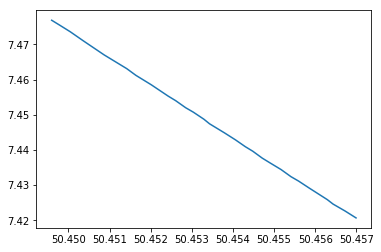

In [38]:
import plotly.graph_objs as go
import pandas as pd
import requests
import matplotlib.pyplot as plt

#We can also use matplotlib and Pandas to visualize the total number of crimes per year
import pandas as pd

%matplotlib inline
trip296_pandas_DataFrame = pd.DataFrame.from_records(trip296.collect(), columns=trip296.columns)
plt.plot(trip296_pandas_DataFrame['latitude'], trip296_pandas_DataFrame['longitude'])

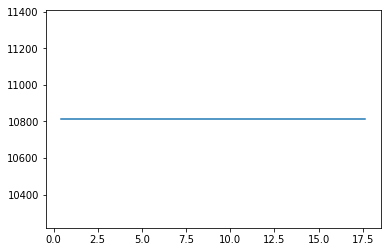

In [39]:
plt.plot(trip296_pandas_DataFrame['timeAtServer'],trip296_pandas_DataFrame['geoAltitude'])

In [40]:
trip296_nearest_airports.columns

['latitude',
 'longitude',
 'geoAltitude',
 'timeAtServer',
 'Hash_Aircraft',
 'name',
 'latitude_deg',
 'longitude_deg',
 'elevation_ft',
 'airport_hash',
 'Distance_2d']

In [41]:
#ploting 3D our aircraft with the nearest airports in each time  in area=S≤ 39.1km × 19.5km
import plotly.offline as py
import numpy as np
trip296_nearest_airports_pandas_DataFrame = pd.DataFrame.from_records(trip296_nearest_airports.collect(), columns=trip296_nearest_airports.columns)
_data = [go.Scatter3d(x=trip296_pandas_DataFrame['latitude'], 
         y=trip296_pandas_DataFrame['longitude'], z=trip296_pandas_DataFrame['geoAltitude'], mode='lines+markers')]
_data1 = [go.Scatter3d(x=trip296_nearest_airports_pandas_DataFrame['latitude_deg'], 
         y=trip296_nearest_airports_pandas_DataFrame['longitude_deg'], z=trip296_nearest_airports_pandas_DataFrame['elevation_ft'], mode='markers')]
py.iplot(_data+_data1)
py.plot(_data+_data1, filename='ploting 3D nearest airoport.html')

'ploting 3D nearest airoport.html'

In [42]:
## Start Position
start = trip296_pandas_DataFrame.iloc[0,:]
## End Position
finish = trip296_pandas_DataFrame.iloc[-1,:]
start['longitude']


7.42067079286318

In [43]:
#using plotly 
import plotly.offline as py
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import json

trip296_nearest_airports_pandas_DataFrame['latitude'] = pd.to_numeric(trip296_nearest_airports_pandas_DataFrame['latitude'],errors='coerce')
trip296_nearest_airports_pandas_DataFrame['longitude'] = pd.to_numeric(trip296_nearest_airports_pandas_DataFrame['longitude'],errors='coerce')
trip296_nearest_airports_pandas_DataFrame['latitude'] = trip296_nearest_airports_pandas_DataFrame['latitude'].astype(float)
trip296_nearest_airports_pandas_DataFrame['longitude'] = trip296_nearest_airports_pandas_DataFrame['longitude'].astype(float)
trip296_nearest_airports_pandas_DataFrame=trip296_nearest_airports_pandas_DataFrame.dropna()
pandas_df = [ dict(
        type = 'scattergeo',
        locationmode = 'ISO-3',
        lon = trip296_nearest_airports_pandas_DataFrame['longitude'],
        lat =trip296_nearest_airports_pandas_DataFrame['latitude'] ,
        hoverinfo = 'text',
        text = trip296_nearest_airports_pandas_DataFrame.Distance_2d,
        mode = 'lines+markers',
        marker = dict(
            size=3,
            color='rgb(255, 20, 147)',
            line = dict(
                width=3,
                color='rgba(68, 68, 68, 0)'
            )
        ) ,
      name='trip296')]

airport_pandas_DataFrame = [ dict(
        type = 'scattergeo',
        locationmode = 'ISO-3',
        lon = trip296_nearest_airports_pandas_DataFrame['longitude_deg'],
        lat =trip296_nearest_airports_pandas_DataFrame['latitude_deg'] ,
        hoverinfo = 'text',
        text =  'name: '+ trip296_nearest_airports_pandas_DataFrame.name+'<br>',
        mode = 'markers',
        marker = dict(
            size=10,
            color='rgb(255, 0, 0)',
            line = dict(
                width=3,
                color='rgba(68, 68, 68, 0)'
            )
        ) ,
      name='airport nearest ')]



layout = dict(
        margin = dict( t = 0, l = 0, r = 0, b = 0 ),
        showlegend = False,         
        geo = dict(
            showland = True,
            showlakes = True,
            showcountries = True,
            showocean = True,
            countrywidth = 0.5,
            landcolor = 'rgb(230, 145, 56)',
            lakecolor = 'rgb(0, 255, 255)',
            oceancolor = 'rgb(0, 255, 255)',
            projection = dict( 
                type = 'orthographic',
                rotation = dict(lon = 0, lat = 0, roll = 0 )            
            ),
            lonaxis = dict( 
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)',
                gridwidth = 0.5
            ),
            lataxis = dict( 
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)',
                gridwidth = 0.5
            )
        )
    )

sliders = []

lon_range = np.arange(-180, 180, 10)
lat_range = np.arange(-90, 90, 10)

sliders.append( 
    dict(
        active = len(lon_range)/2,
        currentvalue = {"prefix": "Longitude: "},
        pad = {"t": 0},
        steps = [{
                'method':'relayout', 
                'label':str(i),
                'args':['geo.projection.rotation.lon', i]} for i in lon_range]
    )      
)

sliders.append( 
    dict(
        active = len(lat_range)/2,
        currentvalue = {"prefix": "Latitude: "},
        pad = {"t": 100},
        steps = [{
                'method':'relayout', 
                'label':str(i),
                'args':['geo.projection.rotation.lat', i]} for i in lat_range]
    )      
)

projections = [ "equirectangular", "mercator", "orthographic", "natural earth","kavrayskiy7", 
               "miller", "robinson", "eckert4", "azimuthal equal area","azimuthal equidistant", 
               "conic equal area", "conic conformal", "conic equidistant", "gnomonic", "stereographic", 
               "mollweide", "hammer", "transverse mercator", "albers usa", "winkel tripel" ]

buttons = [ dict( args=['geo.projection.type', p], label=p, method='relayout' ) for p in projections ]

annot = list([ dict( x=0.1, y=0.8, text='Projection', yanchor='bottom', 
                    xref='paper', xanchor='right', showarrow=False )])

# Update Layout Object

layout[ 'updatemenus' ] = list([ dict( x=0.1, y=0.8, buttons=buttons, yanchor='top' )])

layout[ 'annotations' ] = annot

layout[ 'sliders' ] = sliders
fig = dict( data=airport_pandas_DataFrame +pandas_df , layout=layout )
py.iplot( fig)
py.plot(fig, filename='nearest airoport.html')

'nearest airoport.html'

In [45]:
#from geopy.geocoders import Nominatim, with this we can have a complete description of our departure or end position 
from geopy.distance import geodesic
geolocator = Nominatim(user_agent="change name to address")
location = geolocator.reverse("50.4569929737156,7.42067079286318")
print(location.address)
print(location.raw)

Kehlbachstraße, Hüllenberg, Feldkirchen, Neuwied, Landkreis Neuwied, Rheinland-Pfalz, 56567, Deutschland
{'place_id': 84628260, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 35963506, 'lat': '50.4569915878107', 'lon': '7.42066935433932', 'display_name': 'Kehlbachstraße, Hüllenberg, Feldkirchen, Neuwied, Landkreis Neuwied, Rheinland-Pfalz, 56567, Deutschland', 'address': {'road': 'Kehlbachstraße', 'neighbourhood': 'Hüllenberg', 'suburb': 'Feldkirchen', 'town': 'Neuwied', 'county': 'Landkreis Neuwied', 'state': 'Rheinland-Pfalz', 'postcode': '56567', 'country': 'Deutschland', 'country_code': 'de'}, 'boundingbox': ['50.4543091', '50.4584299', '7.4197924', '7.4227705']}


In [46]:
import numpy as np
trip296_nearest_airports_pandas_DataFrame['timeAtServerint'] = np.arange(len(trip296_nearest_airports_pandas_DataFrame))
trip296_nearest_airports_pandas_DataFrame['timeAtServerint']


0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
24    24
25    25
26    26
27    27
28    28
29    29
30    30
31    31
Name: timeAtServerint, dtype: int32

In [47]:
trip296_nearest_airports_pandas_DataFrame.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 0 to 31
Data columns (total 12 columns):
latitude           32 non-null float64
longitude          32 non-null float64
geoAltitude        32 non-null float64
timeAtServer       32 non-null float64
Hash_Aircraft      32 non-null object
name               32 non-null object
latitude_deg       32 non-null float64
longitude_deg      32 non-null float64
elevation_ft       32 non-null float64
airport_hash       32 non-null object
Distance_2d        32 non-null float64
timeAtServerint    32 non-null int32
dtypes: float64(8), int32(1), object(3)
memory usage: 3.1+ KB


In [48]:
#ploting dynamic  in progress time 
import folium
from folium import plugins
from folium.plugins import HeatMap
map_hooray1 = folium.Map() 

# Ensure you're handing it floats
trip296_nearest_airports_pandas_DataFrame= trip296_nearest_airports_pandas_DataFrame.dropna()


trip296_nearest_airports_pandas_DataFrame1= trip296_nearest_airports_pandas_DataFrame[['latitude','longitude']]# List comprehension to make out list of lists

# Create weight column, using date
trip296_nearest_airports_pandas_DataFrame1['Weight1'] = np.arange(len(trip296_nearest_airports_pandas_DataFrame))
trip296_nearest_airports_pandas_DataFrame1['Weight1'] = trip296_nearest_airports_pandas_DataFrame1['Weight1'].astype(int)

trip296_nearest_airports_pandas_DataFrame1 = trip296_nearest_airports_pandas_DataFrame1.dropna(axis=0, subset=['latitude','longitude', 'Weight1'])

# List comprehension to make out list of lists
trip296_nearest_airports_pandas_DataFrame1 = [[[row['latitude'],row['longitude']] for index, row in trip296_nearest_airports_pandas_DataFrame1[trip296_nearest_airports_pandas_DataFrame1['Weight1'] == i].iterrows()] for i in range(0,len(trip296_nearest_airports_pandas_DataFrame)+1)]

# Plot it on the map
hm = plugins.HeatMapWithTime(trip296_nearest_airports_pandas_DataFrame1 ,
                              auto_play=True,max_opacity=0.8)

hm.add_to(map_hooray1)
map_hooray1

C:\Users\rzouga\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\rzouga\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [49]:
#plot nearest aeroprt in each point 
import folium
from folium import plugins
from folium.plugins import HeatMap
map_hooray= folium.Map() 
trip296_nearest_airports_pandas_DataFrame2= trip296_nearest_airports_pandas_DataFrame[['latitude_deg','longitude_deg']]
trip296_nearest_airports_pandas_DataFrame2['Weight2'] = np.arange(len(trip296_nearest_airports_pandas_DataFrame))
trip296_nearest_airports_pandas_DataFrame2['Weight2'] = trip296_nearest_airports_pandas_DataFrame2['Weight2'].astype(int)
trip296_nearest_airports_pandas_DataFrame2 = trip296_nearest_airports_pandas_DataFrame2.dropna(axis=0, subset=['latitude_deg','longitude_deg', 'Weight2'])
trip296_nearest_airports_pandas_DataFrame2 = [[[row['latitude_deg'],row['longitude_deg']] for index, row in trip296_nearest_airports_pandas_DataFrame2[trip296_nearest_airports_pandas_DataFrame2['Weight2'] == i].iterrows()] for i in range(0,len(trip296_nearest_airports_pandas_DataFrame)+1)]
hm2 = plugins.HeatMapWithTime(trip296_nearest_airports_pandas_DataFrame2,
                              auto_play=True,max_opacity=0.8)
hm2.add_to(map_hooray)
# Display the map
map_hooray

C:\Users\rzouga\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\rzouga\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [50]:
#geohash precesion 4
from pyspark.sql.functions import col
sorted_flights.dropna()

sorted_flights=sorted_flights.where(col("latitude").isNotNull())
sorted_flights=sorted_flights.where(col("longitude").isNotNull())
udf1 = F.udf(lambda x,y: geohash2.encode(x,y,precision=4))
sorted_flights=sorted_flights.select('latitude','longitude','geoAltitude','timeAtServer')
sorted_flights=sorted_flights.withColumn('Hash_Aircraft', udf1('latitude','longitude').cast(StringType()))
sorted_flights.show()


+----------------+----------------+-----------+-----------------+-------------+
|        latitude|       longitude|geoAltitude|     timeAtServer|Hash_Aircraft|
+----------------+----------------+-----------+-----------------+-------------+
|49.8963643736759|8.40246252111487|     2400.3|0.523000001907349|         u0vg|
|49.8959454035355|8.40149750580659|    2407.92| 1.11700010299683|         u0vg|
|49.8956660901086|8.40075518633868|    2415.54| 1.54299998283386|         u0vg|
|49.8952789306641|8.39991519325658|    2423.16| 2.03600001335144|         u0vg|
|49.8945953886388|8.39786014041385|    2446.02| 3.12700009346008|         u0vg|
|49.8939902095471|8.39622703758446|    2461.26| 4.11899995803833|         u0vg|
|49.8936767578125|8.39536164936266|    2461.26| 4.63499999046326|         u0vg|
|49.8933384782177|8.39451970280828|     2476.5|  5.1470000743866|         u0vg|
|49.8929660603152|8.39348045555321|     2476.5| 5.69099998474121|         u0vg|
|49.8926239013672|8.39268734580592|    2

In [51]:
#extract Paris location
>>> from geopy.geocoders import Nominatim
>>> geolocator = Nominatim(user_agent="specify_your_app_name_here")
>>> location = geolocator.geocode("Paris-Orly Airport")
>>> print(location.address)
>>> print((location.latitude, location.longitude))

Best Western Plus Paris Orly Airport, Avenue Charles Lindbergh, Rungis, Arrondissement de L'Haÿ-les-Roses, Val-de-Marne, Île-de-France, France métropolitaine, 94150, France
(48.753404, 2.35070227482561)


In [52]:
#2 method to extract informations about paris airoport
airport_hash.dropna()
airport_hash.filter(airport_hash.name.contains('Luxembourg')).show(10)

+--------------------+------------+-------------+------------+------------+
|                name|latitude_deg|longitude_deg|elevation_ft|airport_hash|
+--------------------+------------+-------------+------------+------------+
|Luxembourg-Findel...|  49.6233333|    6.2044444|      1234.0|        u0u6|
|Centre Hospitalie...|   49.619279|     6.102534|      1079.0|        u0u6|
+--------------------+------------+-------------+------------+------------+



In [53]:
#let's show the nearest aircrafts to Dierdorf Airport in aera S ≤ 39.1km 	× 	19.5km
sorted_flights.dropna()
t=sorted_flights.filter(sorted_flights['Hash_Aircraft']=='u0vr')
t.select('latitude','longitude','geoAltitude','timeAtServer','Hash_Aircraft').show()

+----------------+----------------+-----------+-----------------+-------------+
|        latitude|       longitude|geoAltitude|     timeAtServer|Hash_Aircraft|
+----------------+----------------+-----------+-----------------+-------------+
|50.4569929737156|7.42067079286318|   10812.78|0.425000190734863|         u0vr|
|50.4567260742188|7.42263793945312|   10812.78|0.942000150680542|         u0vr|
|50.4564343468618|7.42460508604308|   10812.78| 1.50300002098084|         u0vr|
|50.4562946901483|7.42586702913851|   10812.78| 1.94500017166138|         u0vr|
|50.4558563232422|7.42914300215872|   10812.78| 3.00600004196167|         u0vr|
| 50.455596406581|7.43113749736064|   10812.78| 3.57500004768372|         u0vr|
|50.4554101976298|7.43239944045608|   10812.78| 4.09000015258789|         u0vr|
|50.4551696777344| 7.4344193307977|   10812.78| 4.61700010299683|         u0vr|
|50.4548981230138|7.43633373363598|   10812.78| 5.13400006294251|         u0vr|
|50.4547119140625|7.43766990867821|   10

In [54]:
#let's show the nearest aircrafts to Luxembourg Airport,hashcode= 'u0u6' in aera S ≤ 39.1km 	× 	19.5km
t2=sorted_flights.filter(sorted_flights.Hash_Aircraft.contains('u0u6'))
t2.select('latitude','longitude','geoAltitude','timeAtServer','Hash_Aircraft').show()

+----------------+----------------+-----------+-----------------+-------------+
|        latitude|       longitude|geoAltitude|     timeAtServer|Hash_Aircraft|
+----------------+----------------+-----------+-----------------+-------------+
|49.7012173927437|6.04314855627112|    11125.2|0.152000188827515|         u0u6|
|49.7010498046875|6.04146857010691|   11117.58|0.611000061035156|         u0u6|
|49.7008666992188| 6.0402398360403|   11117.58| 1.01600003242493|         u0u6|
|  49.70068359375|6.03843287417763|   11117.58| 1.56599998474121|         u0u6|
|49.7004260047007|6.03676460884713|   11117.58| 2.16200017929077|         u0u6|
|49.7001932435117|6.03490881017737|   11117.58| 2.73200011253357|         u0u6|
|49.6999969482422|6.03344565943668|   11117.58| 3.18099999427795|         u0u6|
|49.6998138427734|6.03221692537007|   11117.58| 3.60700011253357|         u0u6|
|49.6996765136719|6.03113274825247|    11125.2| 4.04500007629395|         u0u6|
|49.6996307373047|6.03069907740543|   11

In [55]:
#Let's Estimate 
Estimate_trip296=sorted_flights.filter('aircraft= 296')
Estimate_trip296.where(Estimate_trip296.id == 1).show()

AttributeError: 'DataFrame' object has no attribute 'id'